In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import cv2
import os
import shutil
from tqdm import tqdm
import requests
import re
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options

In [2]:
# Paths
item_csv_path = 'assets/item_data.csv'
item_img_path = 'assets/item_imgs'
joker_template_path = 'assets/templates'
joker_sheet_2x_path = 'assets/2x/isaactro_jokers.png'
joker_sheet_1x_path = 'assets/1x/isaactro_jokers.png'
font_path = 'assets/fonts/IsaacGame.ttf'

# delete and create a new directory
def new_path(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

In [3]:
# get list of items from https://bindingofisaacrebirth.fandom.com/wiki/Items
# and save the name of the item and the image link
# then for each item, download the image and save it
# then create a joker card with the image pasted on it
# then save
# then, join all the joker cards into one image

options = Options()
options.headless = True

driver = webdriver.Firefox(options=options)
driver.get("https://bindingofisaacrebirth.fandom.com/wiki/Items?dlcfilter=3")


# collect items
items = []
item_elements = driver.find_elements(
    By.XPATH, 
    '//table[@class="wikitable mw-collapsible striped sortable jquery-tablesorter mw-made-collapsible"]/tbody/tr[@class="row-collectible"]'
)

# names are at td[1]/a
# images are at EITHER td[3]/div/a/img or td[3]/a/img depending on if it's an active or passive
# quality is at td[6]
# quote is at td[4]/i
print('Collecting items...')
for item_element in tqdm(item_elements):
    # scroll to item element to make sure it is in view
    driver.execute_script("arguments[0].scrollIntoView();", item_element)
    
    # get item image
    try:
        item_img_element = item_element.find_element(By.XPATH, 'td[3]/div/a/img')
    except:
        item_img_element = item_element.find_element(By.XPATH, 'td[3]/a/img')
    
    # wait until image is loaded, the src will be a base64 gif if not loaded
    item_img_link = item_img_element.get_attribute('src')
    while item_img_link.startswith('data:image/gif;base64'):
        item_img_link = item_img_element.get_attribute('src')
    
    # get item name (td[1]/a)
    item_name = item_element.find_element(By.XPATH, 'td[1]/a').text
    
    # get quality (td[6])
    quality = item_element.find_element(By.XPATH, 'td[6]').text
    
    # get item quote (td[3]/i)
    quote = item_element.find_element(By.XPATH, 'td[4]/i').text
    
    items.append((item_name, item_img_link, quality, quote))

driver.quit()

100%|██████████| 719/719 [00:38<00:00, 18.68it/s]


In [4]:
item2quality = {n: q for n, _, q, _ in items}
item2quote = {n: q for n, _, _, q in items}

# download images
print("Downloading images...")
new_path(item_img_path)
item2file = {}
for item_name, item_img_link, *_ in tqdm(items):
    img_data = requests.get(item_img_link).content
    
    # replace non-alphanumeric characters with underscores and spaces with dashes
    img_name = re.sub(r'[^a-zA-Z0-9]', '_', item_name).replace(' ', '-')
    img_path = os.path.join(item_img_path, f'{img_name}.png')
    
    # save image
    with open(img_path, 'wb') as f:
        f.write(img_data)
    
    item2file[item_name] = img_path

100%|██████████| 719/719 [01:58<00:00,  6.07it/s]


In [5]:
# add grid position to each item, grid is 10 columns by however many rows needed
items = [(name, img, quality, quote, (i % 10, i // 10)) for i, (name, img, quality, quote) in enumerate(items)]

# add item img path to each item
items = [(name, item2file[name], quality, quote, pos) for name, _, quality, quote, pos in items]

In [6]:
# create pandas dataframe with item data
print("Saving item data...")
item_df = pd.DataFrame(items, columns=['name', 'img_path', 'quality', 'quote', 'pos'])
item_df.to_csv(item_csv_path, index=False)
item_df.head()

Saving item data...


,name,img_path,quality,quote,pos
0,A Pony,assets/item_imgs\A_Pony.png,2,Flight + dash attack,"(0, 0)"
1,Anarchist Cookbook,assets/item_imgs\Anarchist_Cookbook.png,0,Summon bombs,"(1, 0)"
2,Best Friend,assets/item_imgs\Best_Friend.png,1,Friends 'till the end,"(2, 0)"
3,Blank Card,assets/item_imgs\Blank_Card.png,2,Card mimic,"(3, 0)"
4,Blood Rights,assets/item_imgs\Blood_Rights.png,0,Mass enemy damage at a cost,"(4, 0)"


In [7]:
# read the items file
print("Loading item data...")
items = pd.read_csv(item_csv_path)
items.head()

Loading item data...


,name,img_path,quality,quote,pos
0,A Pony,assets/item_imgs\A_Pony.png,2,Flight + dash attack,"(0, 0)"
1,Anarchist Cookbook,assets/item_imgs\Anarchist_Cookbook.png,0,Summon bombs,"(1, 0)"
2,Best Friend,assets/item_imgs\Best_Friend.png,1,Friends 'till the end,"(2, 0)"
3,Blank Card,assets/item_imgs\Blank_Card.png,2,Card mimic,"(3, 0)"
4,Blood Rights,assets/item_imgs\Blood_Rights.png,0,Mass enemy damage at a cost,"(4, 0)"


In [8]:
# load images and add to column of df
print("Loading images...")
items['img'] = items['img_path'].apply(lambda x: cv2.imread(x, cv2.IMREAD_UNCHANGED))
items.head()

Loading images...


,name,img_path,quality,quote,pos,img
0,A Pony,assets/item_imgs\A_Pony.png,2,Flight + dash attack,"(0, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
1,Anarchist Cookbook,assets/item_imgs\Anarchist_Cookbook.png,0,Summon bombs,"(1, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
2,Best Friend,assets/item_imgs\Best_Friend.png,1,Friends 'till the end,"(2, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
3,Blank Card,assets/item_imgs\Blank_Card.png,2,Card mimic,"(3, 0)","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
4,Blood Rights,assets/item_imgs\Blood_Rights.png,0,Mass enemy damage at a cost,"(4, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."


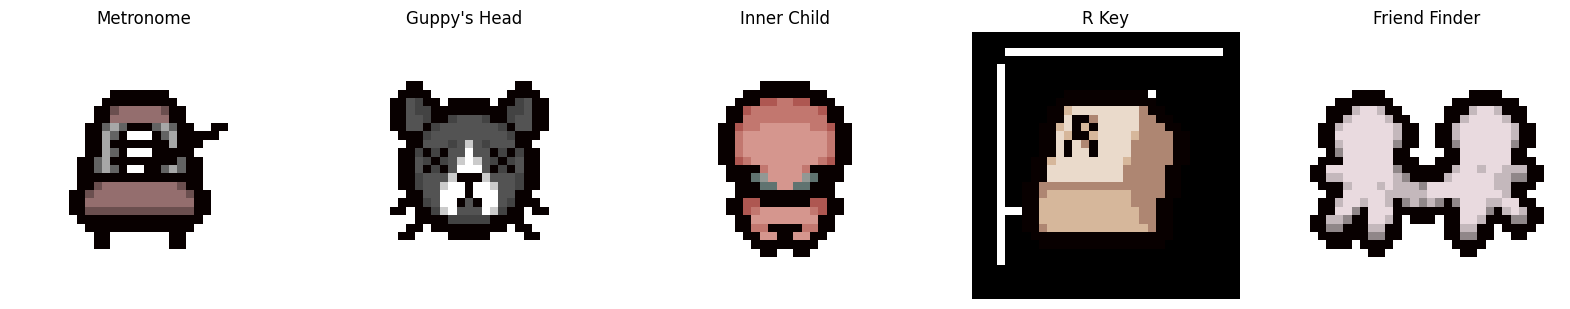

In [9]:
# display 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, (name, img) in enumerate(items[['name', 'img']].sample(5).values):
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title(name)
    axs[i].axis('off')
plt.show()

In [10]:
# process the images
print("Processing images...")
def process_img(img):
    # 2x upscale
    upscaled = np.repeat(np.repeat(img, 2, axis=0), 2, axis=1)
    
    # make sure it is 64x64
    upscaled = cv2.resize(upscaled, (64, 64), interpolation=cv2.INTER_NEAREST)
    return upscaled

items['img'] = items['img'].apply(process_img)

items.head()

Processing images...


,name,img_path,quality,quote,pos,img
0,A Pony,assets/item_imgs\A_Pony.png,2,Flight + dash attack,"(0, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
1,Anarchist Cookbook,assets/item_imgs\Anarchist_Cookbook.png,0,Summon bombs,"(1, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
2,Best Friend,assets/item_imgs\Best_Friend.png,1,Friends 'till the end,"(2, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."
3,Blank Card,assets/item_imgs\Blank_Card.png,2,Card mimic,"(3, 0)","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
4,Blood Rights,assets/item_imgs\Blood_Rights.png,0,Mass enemy damage at a cost,"(4, 0)","[[[255, 255, 255, 0], [255, 255, 255, 0], [255..."


In [11]:
# get the joker templates
blank_jokers = {x: cv2.imread(os.path.join(joker_template_path, f'quality{x}.png'), cv2.IMREAD_UNCHANGED) for x in range(5)}

# create joker cards (without text)
print('Creating joker cards...')
joker_imgs = []
for i, item in tqdm(items.iterrows(), total=len(items)):
    img = item["img"]
    quality = item["quality"]
    
    # joker is 142x190, item is 64x64, paste item in center
    # make sure to only paste where pixels are not transparent
    joker = blank_jokers[quality].copy()
    for i in range(64):
        for j in range(64):
            if img[i, j, 3] > 0:
                joker[63+i, 39+j] = img[i, j]
    
    joker_imgs.append(joker)

# add joker images to df
items['joker'] = joker_imgs

Creating joker cards...


100%|██████████| 719/719 [00:00<00:00, 1200.86it/s]


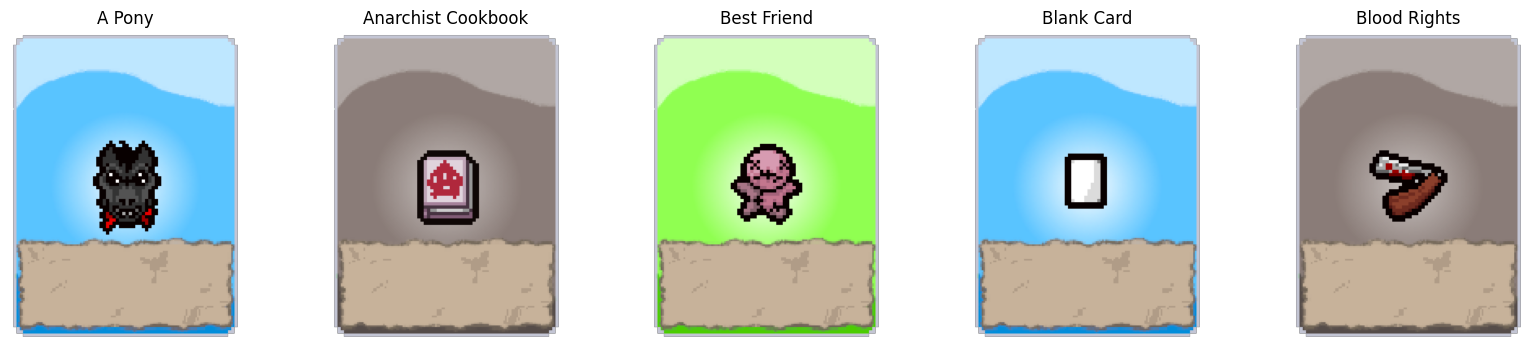

In [12]:
# display the first
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, (joker, name) in enumerate(zip(items['joker'].head(), items['name'].head())):
    # convert to rgb
    joker = cv2.cvtColor(joker, cv2.COLOR_BGRA2RGBA)
    axs[i].imshow(joker)
    axs[i].set_title(name)
    axs[i].axis('off')
plt.show()

In [13]:
# write the quote text on the joker cards
font_size = 16
font = ImageFont.truetype("assets/font/IsaacGame.ttf", font_size)
y_center = 156 # center of the quote text so that it's on the paper area

# add quote text to jokers
jokers_with_text = []
for i, item in tqdm(items.iterrows(), total=len(items)):
    # convert to PIL image
    joker_img = Image.fromarray(cv2.cvtColor(item["joker"], cv2.COLOR_BGRA2RGBA))
    joker_w, joker_h = joker_img.size
    draw = ImageDraw.Draw(joker_img)
    quote = item["quote"]
    
    # split into lines with <= 18 characters
    words = quote.split()
    lines = []
    line = ""
    for word in words:
        if len(line) + len(word) + 1 <= 18:
            line += word + ' '
        else:
            lines.append(line)
            line = word + ' '
    lines.append(line)
    
    # draw each line
    for i, line in enumerate(lines):
        w = draw.textlength(line, font=font)
        h = font_size
        x = (joker_w - w) // 2
        y = y_center - (len(lines) * h) // 2 + i * h
        draw.text((x, y), line, font=font, fill='black')
    
    jokers_with_text.append(cv2.cvtColor(np.array(joker_img), cv2.COLOR_RGBA2BGRA))

# add joker images with text to df
items['joker'] = jokers_with_text

100%|██████████| 719/719 [00:00<00:00, 6402.44it/s]


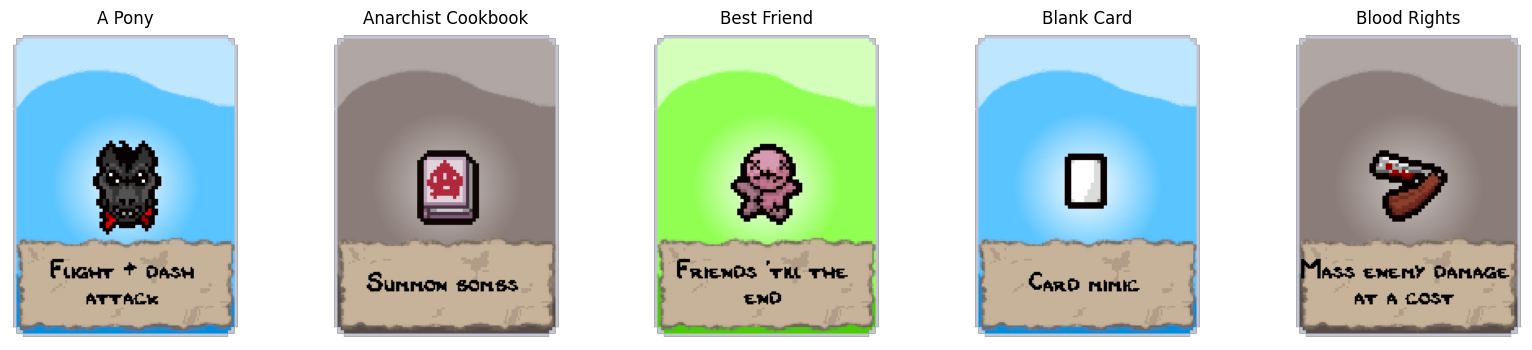

In [14]:
# display the first 5
# display the first 5 joker cards
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, (joker, name) in enumerate(zip(items['joker'].head(), items['name'].head())):
    # convert to rgb
    joker = cv2.cvtColor(joker, cv2.COLOR_BGRA2RGBA)
    axs[i].imshow(joker)
    axs[i].set_title(name)
    axs[i].axis('off')
plt.show()

Joining joker cards...


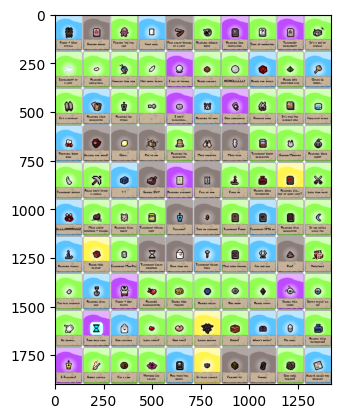

In [15]:
# join the joker cards into one image
# use 10 columns and as many rows as needed
print('Joining joker cards...')

# join jokers with quotes
joker_sheet_2x = np.zeros((190*len(items['joker'])//10 + 190, 142*10, 4), dtype=np.uint8)
for i, joker in enumerate(items['joker']):
    row = i // 10
    col = i % 10
    joker_sheet_2x[row*190:row*190+190, col*142:col*142+142] = joker

# save the joker sheet
cv2.imwrite(joker_sheet_2x_path, joker_sheet_2x)

# show image inline (just the top 10x10)
plt.imshow(cv2.cvtColor(joker_sheet_2x[:1900, :1420], cv2.COLOR_BGRA2RGBA))

In [16]:
# downscale the joker sheet to 1x
downscaled_size = (joker_sheet_2x.shape[1]//2, joker_sheet_2x.shape[0]//2)
joker_sheet_1x = cv2.resize(joker_sheet_2x, downscaled_size, interpolation=cv2.INTER_NEAREST)
cv2.imwrite(joker_sheet_1x_path, joker_sheet_1x)

True

In [17]:
# downscale the tag sheet (assume it was created by hand)
tag_sheet = cv2.imread('assets/2x/isaactro_tags.png', cv2.IMREAD_UNCHANGED)
tag_sheet_1x = cv2.resize(tag_sheet, (tag_sheet.shape[1]//2, tag_sheet.shape[0]//2), interpolation=cv2.INTER_NEAREST)
cv2.imwrite('assets/1x/isaactro_tags.png', tag_sheet_1x)

True